### Version History
* Time_series_forcasting_with_tf_0130_1C, original
* Time_series_forcasting_with_tf_0130_1D, add visuals

### Load the data

In [1]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2023-01-30 18:19:42--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.003s  

2023-01-30 18:19:42 (60.9 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [2]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


### Add Multivariable features, eg Interest Rate

In [3]:
df['Multivar1'] = 1      # This column is extra features such as interest_rate etc
df['Multivar2'] = 2      # Add as many features as needed

EXTRA_FEATURES = 2       # MUST set this variable for correct data model input

In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),Multivar1,Multivar2
Date,,,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349,1,2
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383,1,2
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833,1,2
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816,1,2
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566,1,2


### Prepare Time Series Window

In [5]:
# Setup WINDOW_SIZE and HORIZON
HORIZON = 1                      # HORIZON = 1 daily price prediction
WINDOW_SIZE = 7                  # WINDOW_SIZE = 7  based on previous 7-day historical data

In [6]:
# make a copy of the data set
df_new = df.drop(['Currency', '24h Open (USD)', '24h High (USD)', '24h Low (USD)'], axis=1)

In [7]:
# rename the price column
df_new.rename(columns={"Closing Price (USD)": "Price"}, inplace=True)

In [8]:
df_new.head()

,Price,Multivar1,Multivar2
Date,,,
2013-10-01,123.65499,1,2
2013-10-02,125.45500,1,2
2013-10-03,108.58483,1,2
2013-10-04,118.67466,1,2
2013-10-05,121.33866,1,2


In [9]:
# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  df_new[f"Price+{i+1}"] = df_new["Price"].shift(periods=i+1)
df_new.head()

,Price,Multivar1,Multivar2,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,,
2013-10-01,123.65499,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,1,2,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,1,2,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,1,2,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,1,2,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [10]:
import numpy as np

In [11]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = df_new.dropna().drop("Price", axis=1).astype(np.float32) 
y = df_new.dropna()["Price"].astype(np.float32)
X.head()

,Multivar1,Multivar2,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-08,1.0,2.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,1.0,2.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,1.0,2.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,1.0,2.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,1.0,2.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [12]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [13]:
# Make train and test sets if needed
SPLIT_RATIO = 0.8
split_size = int(len(X) * SPLIT_RATIO)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Project Models

### Project Model 1: LSTM (Window=7,Horizon=1)

In [14]:
# Helper function to save a model

from re import VERBOSE
import os

# function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

In [15]:
import tensorflow as tf
import numpy as np

from tensorflow.keras import layers

In [17]:
# random
tf.random.set_seed(42)

# Model (this is a functional API)
inputs = layers.Input(shape=(WINDOW_SIZE+EXTRA_FEATURES))         
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)   # expand input dimension to comply with tf requirements
x = layers.LSTM(128, activation='relu')(x)                       # default activation is tanh
# x = layers.Dense(32, activation='relu')(x)                     # Add Dense layer here for more complex model
output = layers.Dense(HORIZON)(x)                                # typically HORIZON==1 for daily price prediction
proj_m1 = tf.keras.Model(inputs=inputs, outputs=output, name='proj_m1_LSTM')

# Compile
proj_m1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=['mae','mse'])

# Fit
proj_m1.fit(X_train,
            y_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=proj_m1.name)])

In [18]:
proj_m1.summary()

Model: "proj_m1_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 9)]               0         
                                                                 
 lambda_1 (Lambda)           (None, 1, 9)              0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               70656     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 70,785
Trainable params: 70,785
Non-trainable params: 0
_________________________________________________________________


###### Model Evaluation
* ref: sktime's mase_loss()
* ref: 5.8 Evaluating point forecast accuracy

In [19]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  
  return mae / mae_naive_no_season

In [20]:
# function to return model evaluation metrics
def evaluate_preds(y_true, y_pred):
  '''
  input:  y_true, y_pred, true and predicted value from our model
  output: dictionary of evaluation metrics {mae,mse,rms,mape,mase}
  '''

  # make sure float32 datatype (for metric calculation) to comply with tensorflow requirements, note numpy use float64
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # reduce outputs to single values if HORIZON is greater than 1
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [21]:
# Evaluate on test data
proj_m1.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 597.4324 - mae: 597.4324 - mse: 1251150.5000


[597.432373046875, 597.432373046875, 1251150.5]

In [22]:
# Use the saved best performing model_1 and evaluate it on test data
proj_m1=tf.keras.models.load_model('/content/model_experiments/proj_m1_LSTM')
proj_m1.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 581.1559 - mae: 581.1559 - mse: 1217954.1250


[581.1558837890625, 581.1558837890625, 1217954.125]

###### Make function to forecasts on the test dataset
1.  Take in a trained model
2.  Take in some test data
3.  Use model.predict() to predict
4.  Return the predictions

In [23]:
def make_preds(model, input_data):
  '''
  Input: 
         model, trained model
         input_data: test_data in the same format as training_data
  return: prediction
  '''
  forecast = model.predict(input_data)
  return tf.squeeze(forecast)  # return 1D array of prediction

In [24]:
# Make predictions using model_1
proj_m1_preds = make_preds(proj_m1, X_test)

18/18 [==============================] - 0s 2ms/step


In [25]:
# Evaluate preds
proj_m1_results = evaluate_preds(y_true=y_test,
                                 y_pred=proj_m1_preds)
proj_m1_results

{'mae': 581.1559,
 'mse': 1217954.1,
 'rmse': 1103.6096,
 'mape': 2.6226254,
 'mase': 1.0209299}

In [28]:
# Helper plot function

# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("Stock Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

In [29]:
import matplotlib.pyplot as plt

# Try out our plotting function
#DEBUG plt.figure(figsize=(10, 7))
#DEBUG plot_time_series(timesteps=y_train.index.to_numpy(), values=y_train, label="Train data")
#DEBUG plot_time_series(timesteps=y_test.index.to_numpy(), values=y_test, label="Test data")

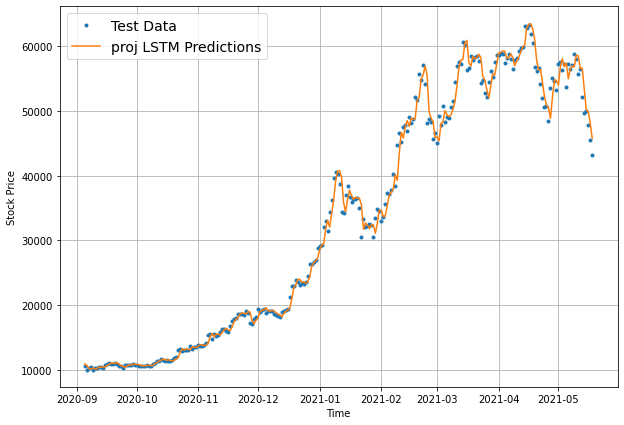

In [31]:
# VISUAL

offset = 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=y_test.index.to_numpy(),
                 values=y_test,
                 start=offset,
                 label='Test Data')
plot_time_series(timesteps=y_test.index.to_numpy(),
                 values=proj_m1_preds,
                 start=offset,
                 format='-',
                 label='proj LSTM Predictions')

### Project Model2: Stack LSTM

In [32]:
# random
tf.random.set_seed(42)

# Model (this is a functional API)
inputs = layers.Input(shape=(WINDOW_SIZE+EXTRA_FEATURES))         
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)   # expand input dimension to comply with tf requirements
x = layers.LSTM(128, return_sequences=True)(x)                   # use this layer if we want to stack the layers by routing the output to the next input
x = layers.LSTM(128, activation='relu')(x)                       # default activation is tanh
# x = layers.Dense(32, activation='relu')(x)                     # Add Dense layer here for more complex model
output = layers.Dense(HORIZON)(x)                                # typically HORIZON==1 for daily price prediction
proj_m2 = tf.keras.Model(inputs=inputs, outputs=output, name='proj_m2_stackLSTM')

# Compile
proj_m2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=['mae','mse'])

# Fit
proj_m2.fit(X_train,
            y_train,
            epochs=10,
            verbose=0,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=proj_m2.name)])

In [33]:
proj_m2.summary()

Model: "proj_m2_stackLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 9)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 9)              0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 128)            70656     
                                                                 
 lstm_3 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 202,369
Trainable params: 202,369
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Evaluate with Test data
proj_m2.evaluate(X_test, y_test)

18/18 [==============================] - 0s 8ms/step - loss: 19865.9570 - mae: 19865.9570 - mse: 701852928.0000


[19865.95703125, 19865.95703125, 701852928.0]

In [35]:
# Use saved best performing model to evaluate test data
proj_m2=tf.keras.models.load_model('/content/model_experiments/proj_m2_stackLSTM')
proj_m2.evaluate(X_test, y_test)

18/18 [==============================] - 1s 3ms/step - loss: 19865.9570 - mae: 19865.9570 - mse: 701852928.0000


[19865.95703125, 19865.95703125, 701852928.0]

In [36]:
# Predictions on Test data
proj_m2_preds = make_preds(proj_m2, X_test)

18/18 [==============================] - 0s 2ms/step


In [37]:
# Evaluate predictions
proj_m2_results = evaluate_preds(y_true=y_test,
                                 y_pred=proj_m2_preds)
proj_m2_results

{'mae': 19865.957,
 'mse': 701852900.0,
 'rmse': 26492.508,
 'mape': 98.067406,
 'mase': 34.898983}

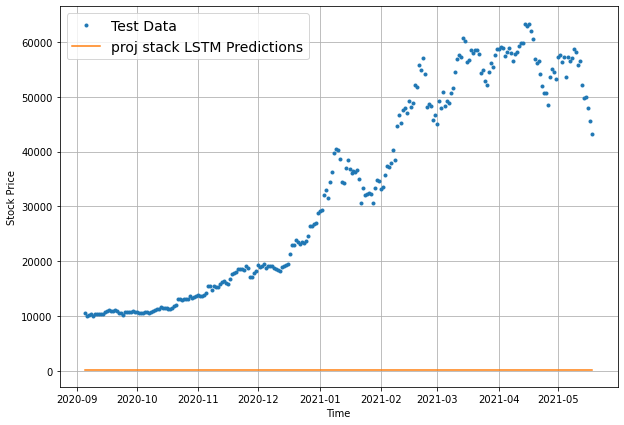

In [38]:
# VISUAL
offset = 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=y_test.index.to_numpy(),
                 values=y_test,
                 start=offset,
                 label='Test Data')
plot_time_series(timesteps=y_test.index.to_numpy(),
                 values=proj_m2_preds,
                 start=offset,
                 format='-',
                 label='proj stack LSTM Predictions')

### Project Model3: BiLSTM

In [40]:
from tensorflow.keras.layers import LSTM

In [41]:
# random
tf.random.set_seed(42)

# Model (this is a functional API)
inputs = layers.Input(shape=(WINDOW_SIZE+EXTRA_FEATURES))         
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)   # expand input dimension to comply with tf requirements

x = layers.Bidirectional(LSTM(128, activation='relu'))(x)        # default activation is tanh
# x = layers.Dense(32, activation='relu')(x)                     # Add Dense layer here for more complex model
output = layers.Dense(HORIZON)(x)                                # typically HORIZON==1 for daily price prediction
proj_m3 = tf.keras.Model(inputs=inputs, outputs=output, name='proj_m3_BiLSTM')

# Compile
proj_m3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
                metrics=['mae','mse'])

# Fit
proj_m3.fit(X_train,
            y_train,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=proj_m3.name)])

In [42]:
proj_m3.summary()

Model: "proj_m3_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 9)]               0         
                                                                 
 lambda_4 (Lambda)           (None, 1, 9)              0         
                                                                 
 bidirectional (Bidirectiona  (None, 256)              141312    
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 141,569
Trainable params: 141,569
Non-trainable params: 0
_________________________________________________________________


In [43]:
# Evaluate on Test data
proj_m3.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 582.4898 - mae: 582.4898 - mse: 1217115.1250


[582.4898071289062, 582.4898071289062, 1217115.125]

In [44]:
# Evaluate with saved best performing model
proj_m3=tf.keras.models.load_model('/content/model_experiments/proj_m3_BiLSTM')
proj_m3.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 582.4898 - mae: 582.4898 - mse: 1217115.1250


[582.4898071289062, 582.4898071289062, 1217115.125]

In [45]:
# Prediction using Test data
proj_m3_preds = make_preds(proj_m3, X_test)

18/18 [==============================] - 0s 2ms/step


In [46]:
# Evaluate predictions
proj_m3_results = evaluate_preds(y_true=y_test,
                                 y_pred=proj_m3_preds)
proj_m3_results

{'mae': 582.4898,
 'mse': 1217115.1,
 'rmse': 1103.2294,
 'mape': 2.6109638,
 'mase': 1.0232732}

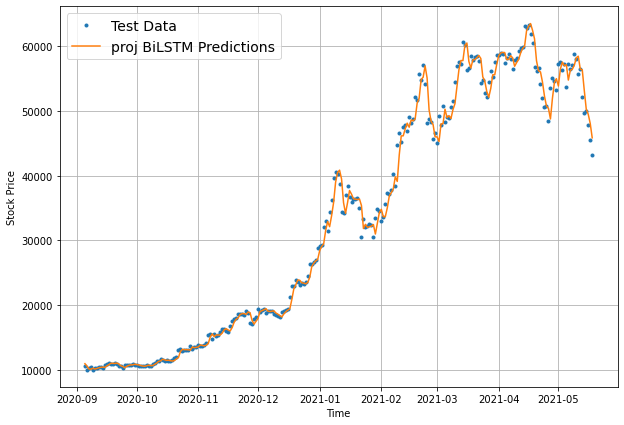

In [51]:
# VISUAL
offset = 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=y_test.index.to_numpy(),
                 values=y_test,
                 start=offset,
                 label='Test Data')
plot_time_series(timesteps=y_test.index.to_numpy(),
                 values=proj_m3_preds,
                 start=offset,
                 format='-',
                 label='proj BiLSTM Predictions')

### Model Comparison
* Our Results so far

In [49]:
print(proj_m1_results)
print(proj_m2_results)
print(proj_m3_results)

{'mae': 581.1559, 'mse': 1217954.1, 'rmse': 1103.6096, 'mape': 2.6226254, 'mase': 1.0209299}
{'mae': 19865.957, 'mse': 701852900.0, 'rmse': 26492.508, 'mape': 98.067406, 'mase': 34.898983}
{'mae': 582.4898, 'mse': 1217115.1, 'rmse': 1103.2294, 'mape': 2.6109638, 'mase': 1.0232732}


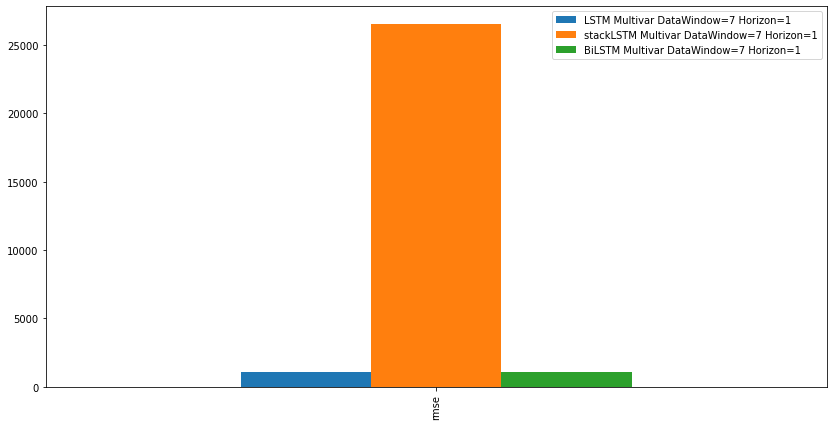

In [50]:
# results from our models so far
pd.DataFrame({'LSTM Multivar DataWindow=7 Horizon=1': proj_m1_results['rmse'],
              'stackLSTM Multivar DataWindow=7 Horizon=1': proj_m2_results['rmse'],
              'BiLSTM Multivar DataWindow=7 Horizon=1': proj_m3_results['rmse']
              },index=['rmse']).plot(figsize=(14,7),kind='bar')

## Modeling Experiments DO NOT USE

## Model 0: Naive forecast (baseline) for a horizon of 1
$$\hat{y}_(t) = y_(t-1)$$

The prediction at timestep t(y-hat) is equal to the vale at timestep t-1(previous timestep)

In [ ]:
# naive forecast for a horizon of 1
naive_forecast = y_test[:-1]

# DEBUG y_test[-10:]
# DEBUG naive_forecast[-10:]

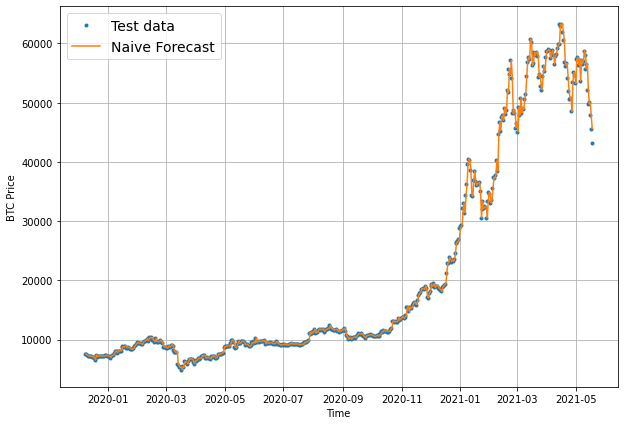

In [ ]:
# Visual
plt.figure(figsize=(10,7))
# plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, start=30, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=30, format='-', label='Naive Forecast')

In [ ]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  
  return mae / mae_naive_no_season

  # DEBUG mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

In [ ]:
# DEBUG mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

In [ ]:
# function to return model evaluation metrics
def evaluate_preds(y_true, y_pred):
  '''
  input:  y_true, y_pred, true and predicted value from our model
  output: dictionary of evaluation metrics {mae,mse,rms,mape,mase}
  '''

  # make sure float32 datatype (for metric calculation) to comply with tensorflow requirements, note numpy use float64
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # reduce outputs to single values if HORIZON is greater than 1
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {'mae': mae.numpy(),
          'mse': mse.numpy(),
          'rmse': rmse.numpy(),
          'mape': mape.numpy(),
          'mase': mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

## Model 1: Dense (window=7, horizon=1)

* simple dense layer with 128 hidden units and ReLU
* output layer with linear activation
* Adam optimizer and MAE loss function
* Batch size of 128(typical for time-series)
* 100 epochs

In [ ]:
# Model1: simple Dense model, 128 hidden units, ReLU
import tensorflow as tf
from tensorflow.keras import layers

# random seed
tf.random.set_seed(42)

# Model
model_1 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    # add extra layers here
    layers.Dense(HORIZON,                      # typically HORIZON==1
                 activation='linear')
], name='model_1_dense')

# Compile
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae','mse'])

# Fit
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 128)               1024      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9758 - mae: 585.9758 - mse: 1197802.1250


[585.9757690429688, 585.9757690429688, 1197802.125]

In [ ]:
# Use the saved best performing model_1 and evaluate it on test data
model_1=tf.keras.models.load_model('/content/model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171743.6250


[568.9510498046875, 568.9510498046875, 1171743.625]

In [ ]:
# Make predictions using model_1
model_1_preds = make_preds(model_1, test_windows)
# DEBUG len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 1ms/step


In [ ]:
# DEBUG tf.squeeze(test_labels).shape, model_1_preds.shape

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 568.9511,
 'mse': 1171743.8,
 'rmse': 1082.4711,
 'mape': 2.5448983,
 'mase': 0.99948955}

In [ ]:
# DEBUG test_labels.shape

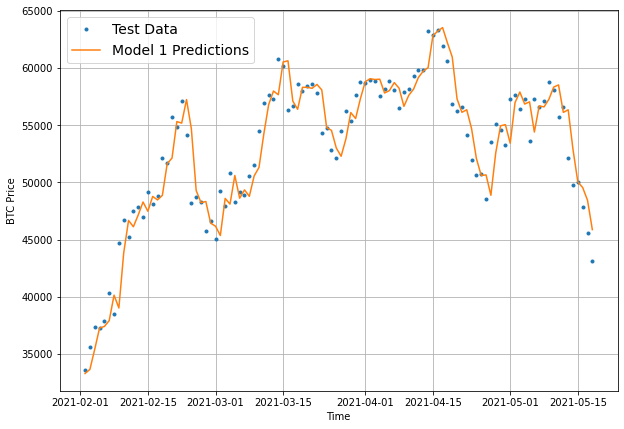

In [ ]:
# Plot
offset = 450
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:,0], 
                 start=offset, label='Test Data')

plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=model_1_preds,
                 format='-',
                 start=offset, label='Model 1 Predictions')

## Model 2: Dense (Window=30, horizon=1)

###### ref: https://otexts.com/fpp3/acf.html

In [ ]:
HORIZON = 1   # predict one day of stock price
WINDOW_SIZE = 30

In [ ]:
# Make windowed data with new window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train/test split
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
len(train_windows[0])

30

In [ ]:
# DEBUG train_windows[:3], train_labels[:3]

In [ ]:
# Model2: simple Dense model, 128 hidden units, ReLU

# random seed
tf.random.set_seed(42)

# Model
model_2 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    # add extra layers here
    layers.Dense(HORIZON,                      # typically HORIZON==1
                 activation='linear')
], name='model_2_dense')

# Compile
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae','mse'])

# Fit
model_2.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               3968      
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 659.3332 - mae: 659.3332 - mse: 1397247.7500


[659.3331909179688, 659.3331909179688, 1397247.75]

In [ ]:
# Evaluate with best saved model_2

# load the best saved model_2
model_2 = tf.keras.models.load_model('/content/model_experiments/model_2_dense')
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 605.8741 - mae: 605.8741 - mse: 1273360.7500


[605.8740844726562, 605.8740844726562, 1273360.75]

In [ ]:
# prediction on test data
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [ ]:
# DEBUG tf.squeeze(test_labels).shape, model_2_preds.shape

In [ ]:
# Evaluate results for model_2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 605.8741,
 'mse': 1273360.8,
 'rmse': 1128.4329,
 'mape': 2.726445,
 'mase': 1.0590738}

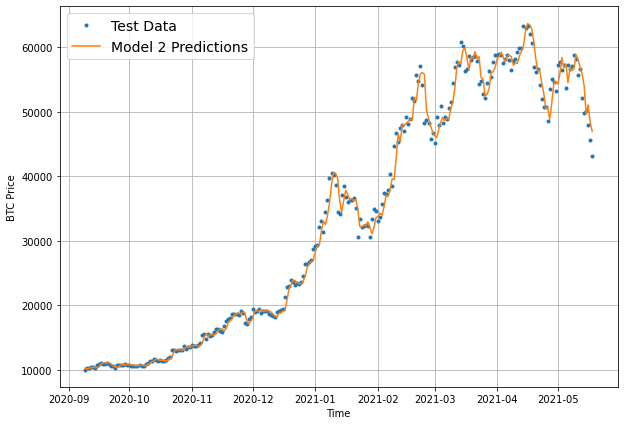

In [ ]:
# Visual
offset = 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=offset,
                 label='Test Data')
plot_time_series(X_test[-len(test_windows):],
                 values=model_2_preds,
                 start=offset,
                 format='-',
                 label='Model 2 Predictions')

## Model 3: Dense (Window=30, Horizon=7)

In [ ]:
HORIZON = 7   # predict 7 day of stock price into the future
WINDOW_SIZE = 30

In [ ]:
# Make windowed data with new window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
# Make train/test split
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
len(train_windows[0]), len(train_labels[0])

(30, 7)

In [ ]:
# DEBUG train_windows[:3], train_labels[:3]

In [ ]:
# Model3: simple Dense model, 128 hidden units, ReLU

# random seed
tf.random.set_seed(42)

# Model
model_3 = tf.keras.Sequential([
    layers.Dense(128,activation='relu'),
    # add extra layers here
    layers.Dense(HORIZON,                      # typically HORIZON=1 for daily prediction, 7 for weekly prediction
                 activation='linear')
], name='model_3_dense')

# Compile
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['mae','mse'])

# Fit
model_3.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
model_3.summary()

Model: "model_3_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               3968      
                                                                 
 dense_6 (Dense)             (None, 7)                 903       
                                                                 
Total params: 4,871
Trainable params: 4,871
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate on test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1300.1525 - mae: 1300.1525 - mse: 5599956.0000


[1300.1524658203125, 1300.1524658203125, 5599956.0]

In [ ]:
# Load the saved best performing model3 and evaluate on test dat
model_3 = tf.keras.models.load_model('/content/model_experiments/model_3_dense')
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1237.5065 - mae: 1237.5065 - mse: 5405199.0000


[1237.5064697265625, 1237.5064697265625, 5405199.0]

In [ ]:
# Make prediction with Model_3
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [ ]:
# Metrics for model_3 results
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1237.5065,
 'mse': 5405198.5,
 'rmse': 1425.7478,
 'mape': 5.558879,
 'mase': 2.2020733}

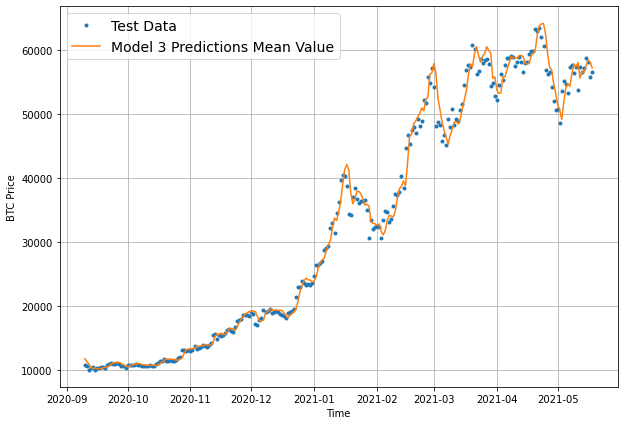

In [ ]:
# Visual
offset = 300
plt.figure(figsize=(10,7))

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=offset,
                 label='Test Data')
plot_time_series(X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 start=offset,
                 format='-',
                 label='Model 3 Predictions Mean Value')

## Model 4: Temporal Convolution Conv1D (Window=7 Horizon=1)

In [ ]:
# reset Window and Horizon
HORIZON = 1       # predict next day price
WINDOW_SIZE = 7   # 7 day worth of data

In [ ]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Train/Test split
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

In [ ]:
# per tf, we need an input shape of '(batch size, timesteps, input_dim)'

In [ ]:
# our data shape
# DEBUG train_windows[0].shape

In [ ]:
# DEBUG x = tf.constant(train_windows[0])
# DEBUG x

In [ ]:
# ref tf.keras.layes.Lambda# expand dimension for input dim
# DEBUG expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))

In [ ]:
# DEBUG print(f"Original shape: {x.shape}")
# DEBUG print(f"Expanded shape: {expand_dims_layer(x).shape}")

In [ ]:
# The model Temporal Convolution

# random
tf.random.set_seed(42)

# Model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),     # adjust data dimension to comply with tf requirement
    layers.Conv1D(filters=128, kernel_size=5, strides=1, 
                  padding='causal',activation='relu'),      # filters = no. of neurons
    # add extra layers here
    layers.Dense(HORIZON)                                   # output layer, typically HORIZON=1 for daily price prediction
], name='model_4_conv1D')

# Compile
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_7 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate 
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 610.1541


610.154052734375

In [ ]:
# Evaluate with our saved best performing model

# load the save model
model_4 = tf.keras.models.load_model('/content/model_experiments/model_4_conv1D')
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 570.8284


570.828369140625

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)

18/18 [==============================] - 0s 2ms/step


In [ ]:
# Evaluate predictions with metrics
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 570.82837,
 'mse': 1176671.2,
 'rmse': 1084.7448,
 'mape': 2.5593357,
 'mase': 1.0027874}

## Model 5: LSTM (Window=7,Horizon=1)

In [ ]:
# random
tf.random.set_seed(42)

# Model (this is a functional API)
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)   # expand input dimension to comply with tf requirements
# x = layers.LSTM(128, return_sequences=True)(x)                 # use this layer if we want to stack the layers by routing the output to the next input
x = layers.LSTM(128, activation='relu')(x)                       # default activation is tanh
# x = layers.Dense(32, activation='relu')(x)                     # Add Dense layer here for more complex model
output = layers.Dense(HORIZON)(x)                                # typically HORIZON==1 for daily price prediction
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name='model_5_LSTM')

# Compile
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001))

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 3s 105ms/step - loss: 2323.6082 - val_loss: 9222.6523
Epoch 2/100
18/18 [==============================] - 2s 94ms/step - loss: 695.4739 - val_loss: 1486.0555
Epoch 3/100
18/18 [==============================] - 2s 94ms/step - loss: 237.3967 - val_loss: 1298.9084
Epoch 4/100
18/18 [==============================] - 2s 111ms/step - loss: 181.9180 - val_loss: 966.6431
Epoch 5/100
18/18 [==============================] - 0s 7ms/step - loss: 173.4022 - val_loss: 970.9295
Epoch 6/100
18/18 [==============================] - 2s 96ms/step - loss: 173.5414 - val_loss: 941.4746
Epoch 7/100
18/18 [==============================] - 2s 92ms/step - loss: 170.3566 - val_loss: 898.5215
Epoch 8/100
18/18 [==============================] - 0s 6ms/step - loss: 157.6712 - val_loss: 914.8642
Epoch 9/100
18/18 [==============================] - 0s 7ms/step - loss: 166.5143 - val_loss: 1079.0776
Epoch 10/100
18/18 [==============================] - 2s 93m

In [ ]:
model_5.summary()

Model: "model_5_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 lambda_2 (Lambda)           (None, 1, 7)              0         
                                                                 
 lstm_1 (LSTM)               (None, 128)               69632     
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Evaluate
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 595.9847


595.9847412109375

In [ ]:
# Evaluate with saved best version of model_5
model_5 = tf.keras.models.load_model('/content/model_experiments/model_5_LSTM')
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 594.6030


594.6029663085938

In [ ]:
# Make prediction
model_5_preds = make_preds(model_5, test_windows)

18/18 [==============================] - 0s 2ms/step


In [ ]:
# Evaluate the predictions
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 594.60297,
 'mse': 1267231.9,
 'rmse': 1125.7139,
 'mape': 2.6717565,
 'mase': 1.0445527}